In [1]:
%reload_ext autoreload
%autoreload 2

import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from sklearn.cluster import KMeans
import statsmodels.api as sm
from lib import utils


mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['font.size'] = 16

In [2]:
df = pd.read_csv('valid_sequence_data.csv',index_col=0)

In [3]:
# If data is clustered to three groups, one of these groups only has 9 subjects
# This explains why we only cluster subjects to two groups 
df_time_pivot_2 = df.pivot(index='worker_id', columns='reward', values='value_surplus')
kmeans = KMeans(n_clusters=3,random_state=42)
kmeans.fit(df_time_pivot_2.values)
print('Number of participants in each cluster:',np.bincount(kmeans.labels_))

c:\users\PHD19ZW1\Appdata\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of participants in each cluster: [105  43   9]


In [4]:
# Spearman rank-order correlation
# the entire sample
print(stats.spearmanr(df['value_surplus'],df['front_amount']))

# cluster 1
print(stats.spearmanr(df[df['label_kmeans'] == 0]['value_surplus'],
                df[df['label_kmeans'] == 0]['front_amount']))

# cluster 2
print(stats.spearmanr(df[df['label_kmeans'] == 1]['value_surplus'],
                    df[df['label_kmeans'] == 1]['front_amount']))

SignificanceResult(statistic=-0.043245998593847375, pvalue=0.04263276342226129)
SignificanceResult(statistic=-0.17557494143900643, pvalue=1.189944758721708e-06)
SignificanceResult(statistic=-0.016437572770570754, pvalue=0.5328273275241426)


In [5]:
df['front_amount_6m'] = df['front_amount'] * (df['seq_length'] == '6 months')
df['front_amount_12m'] = df['front_amount'] * (df['seq_length'] == '12 months')
df['front_amount_6m_0'] = df['front_amount_6m']  * (df['label_kmeans'] == 0)
df['front_amount_6m_1'] = df['front_amount_6m']  * (df['label_kmeans'] == 1)
df['front_amount_12m_0'] = df['front_amount_12m']  * (df['label_kmeans'] == 0)
df['front_amount_12m_1'] = df['front_amount_12m']  * (df['label_kmeans'] == 1)


df_dummy = pd.concat([df,pd.get_dummies(df['worker_id'], prefix='worker_id')],axis=1)
df_filtered = utils.rule_out_outlier(df_dummy,col_name='value_surplus')

reg_cols_baseline = ['front_amount_6m','front_amount_12m','choice_peli']
reg_cols_label = ['front_amount_6m_0','front_amount_12m_0','front_amount_6m_1','front_amount_12m_1','choice_peli']
reg_cols_dummy = reg_cols_baseline + [col for col in df_dummy.columns if col.startswith('worker_id_')]
reg_cols_dummy_2 = reg_cols_label + [col for col in df_dummy.columns if col.startswith('worker_id_')]

y = df_filtered['value_surplus']
X = sm.add_constant(df_filtered[reg_cols_baseline]).astype(float)

model_ols_pool_1 = sm.OLS(endog = y , exog = X).fit()
model_ols_pool_1.summary()

Number of outliers (lower and upper): [4, 8]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_surplus   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.279
Date:                Sun, 04 Feb 2024   Prob (F-statistic):              0.280
Time:                        03:35:12   Log-Likelihood:                -9764.9
No. Observations:                2186   AIC:                         1.954e+04
Df Residuals:                    2182   BIC:                         1.956e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               53.7423      1.213     44.308      0.000      51.364      56.121
front_amount_6m     -0.0053      0.003     -1.676      0.094      -0.012       0.001
front_amount_12m    -0.0056      0.003     -1.775      0.076      -0.012       0.001
choice_peli         -0.2385      1.085     -0.220      0.826      -2.366       1.889
==============================================================================
Omnibus:                      238.466   Durbin-Watson:                   0.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1943.544
Skew:                          -0.133   Prob(JB):                         0.00
Kurtosis:                       7.612   Cond. No.                         729.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
y = df_filtered['value_surplus']
X = sm.add_constant(df_filtered[reg_cols_label]).astype(float)
model_ols_pool_2 = sm.OLS(endog = y , exog = X).fit()
model_ols_pool_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          value_surplus   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     219.9
Date:                Sun, 04 Feb 2024   Prob (F-statistic):          2.42e-190
Time:                        03:35:12   Log-Likelihood:                -9320.5
No. Observations:                2186   AIC:                         1.865e+04
Df Residuals:                    2180   BIC:                         1.869e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 53.7524      0.990     54.283      0.000      51.811      55.694
front_amount_6m_0     -0.0590      0.003    -17.002      0.000      -0.066      -0.052
front_amount_12m_0    -0.0603      0.003    -17.322      0.000      -0.067      -0.053
front_amount_6m_1      0.0230      0.003      8.049      0.000       0.017       0.029
front_amount_12m_1     0.0233      0.003      8.130      0.000       0.018       0.029
choice_peli           -0.2797      0.886     -0.316      0.752      -2.017       1.457
==============================================================================
Omnibus:                      415.403   Durbin-Watson:                   0.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5450.652
Skew:                           0.497   Prob(JB):                         0.00
Kurtosis:                      10.672   Cond. No.                         590.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
y = df_filtered['value_surplus']
X = sm.add_constant(df_filtered[reg_cols_dummy]).astype(float)
model_ols_fe = sm.OLS(endog = y , exog = X).fit()

pd.concat([model_ols_fe.params[reg_cols_baseline].rename('coef'),
           model_ols_fe.pvalues[reg_cols_baseline].rename('pvalues'),
           model_ols_fe.conf_int().loc[reg_cols_baseline].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m,-0.005040,0.007445,-0.008729,-0.001350
front_amount_12m,-0.005306,0.004954,-0.009006,-0.001607
choice_peli,1.185399,0.051584,-0.008150,2.378948


In [8]:
y = df_filtered['value_surplus']
X = sm.add_constant(df_filtered[reg_cols_dummy_2]).astype(float)
model_ols_fe_2 = sm.OLS(endog = y , exog = X).fit()

pd.concat([model_ols_fe_2.params[reg_cols_label].rename('coef'),
           model_ols_fe_2.pvalues[reg_cols_label].rename('pvalues'),
           model_ols_fe_2.conf_int().loc[reg_cols_label].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m_0,-0.018557,5.945329e-09,-0.024786,-0.012329
front_amount_12m_0,-0.020008,3.986979e-10,-0.026250,-0.013765
front_amount_6m_1,0.002069,3.691585e-01,-0.002448,0.006587
front_amount_12m_1,0.002432,2.925102e-01,-0.002098,0.006963
choice_peli,1.190522,4.856262e-02,0.007520,2.373523


In [9]:
y = df['value_surplus']
X = sm.add_constant(df[reg_cols_baseline]).astype(float)
model_rlm_pool_1 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())
model_rlm_pool_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Robust linear Model Regression Results                                            
==============================================================================================================================
Dep. Variable:                                                          value_surplus   No. Observations:                 2198
Model:                                                                            RLM   Df Residuals:                     2194
Method:                                                                          IRLS   Df Model:                            3
Norm:                                                                          HuberT                                         
Scale Est.:        <statsmodels.robust.scale.HuberScale object at 0x000001CEA726FD60>                                         
Cov Type:                                                                          H1                                         
Date:                                                                Sun, 04 Feb 2024                                         
Time:                                                                        03:35:13                                         
No. Iterations:                                                                    12                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               55.0002      0.963     57.084      0.000      53.112      56.889
front_amount_6m     -0.0048      0.003     -1.920      0.055      -0.010       0.000
front_amount_12m    -0.0060      0.003     -2.397      0.017      -0.011      -0.001
choice_peli         -0.8484      0.861     -0.985      0.324      -2.536       0.839
====================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [10]:
y = df['value_surplus']
X = sm.add_constant(df[reg_cols_label]).astype(float)
model_rlm_pool_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())
model_rlm_pool_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Robust linear Model Regression Results                                            
==============================================================================================================================
Dep. Variable:                                                          value_surplus   No. Observations:                 2198
Model:                                                                            RLM   Df Residuals:                     2192
Method:                                                                          IRLS   Df Model:                            5
Norm:                                                                          HuberT                                         
Scale Est.:        <statsmodels.robust.scale.HuberScale object at 0x000001CEA7283BE0>                                         
Cov Type:                                                                          H1                                         
Date:                                                                Sun, 04 Feb 2024                                         
Time:                                                                        03:35:13                                         
No. Iterations:                                                                    20                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 55.5403      0.730     76.090      0.000      54.110      56.971
front_amount_6m_0     -0.0590      0.003    -22.993      0.000      -0.064      -0.054
front_amount_12m_0    -0.0643      0.003    -25.078      0.000      -0.069      -0.059
front_amount_6m_1      0.0155      0.002      7.323      0.000       0.011       0.020
front_amount_12m_1     0.0152      0.002      7.211      0.000       0.011       0.019
choice_peli           -0.6821      0.652     -1.046      0.296      -1.961       0.596
======================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [11]:
y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy]).astype(float)
model_rlm_fe = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())

pd.concat([model_rlm_fe.params[reg_cols_baseline].rename('coef'),
           model_rlm_fe.pvalues[reg_cols_baseline].rename('pvalues'),
           model_rlm_fe.conf_int().loc[reg_cols_baseline].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m,-0.004768,1.405737e-06,-0.006705,-0.002831
front_amount_12m,-0.006412,8.714686e-11,-0.008349,-0.004475
choice_peli,2.181327,7.852493e-12,1.556390,2.806263


In [12]:
y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy_2]).astype(float)
model_rlm_fe_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())

pd.concat([model_rlm_fe_2.params[reg_cols_label].rename('coef'),
           model_rlm_fe_2.pvalues[reg_cols_label].rename('pvalues'),
           model_rlm_fe_2.conf_int().loc[reg_cols_label].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m_0,-0.016540,5.704333e-24,-0.019750,-0.013329
front_amount_12m_0,-0.021410,4.883957e-39,-0.024621,-0.018199
front_amount_6m_1,0.000059,9.605369e-01,-0.002266,0.002383
front_amount_12m_1,-0.000203,8.641333e-01,-0.002528,0.002122
choice_peli,2.279011,1.934018e-13,1.671557,2.886466


NormaltestResult(statistic=1407.782552565554, pvalue=2.0132738404586662e-306)


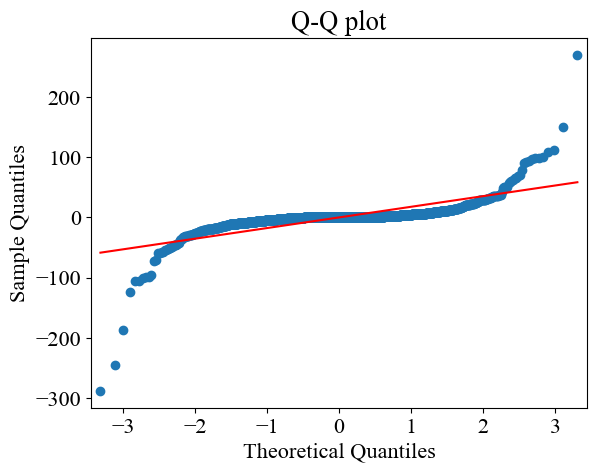

In [13]:
pplot = sm.ProbPlot(model_rlm_fe_2.resid)
fig = pplot.qqplot(line='s')
plt.title('Q-Q plot')
print(stats.normaltest(model_rlm_fe_2.resid))

In [14]:
# save regression results
model_results = {'ols_pool_baseline':utils.get_reg_result(model_ols_pool_1,reg_cols_baseline),
                 'ols_pool_label':utils.get_reg_result(model_ols_pool_2,reg_cols_baseline),
                 'ols_fe_baseline':utils.get_reg_result(model_ols_fe,reg_cols_baseline),
                 'ols_fe_label':utils.get_reg_result(model_ols_fe_2,reg_cols_label),
                 'rlm_pool_baseline':utils.get_reg_result(model_rlm_pool_1,reg_cols_baseline),
                 'rlm_pool_label':utils.get_reg_result(model_rlm_pool_2,reg_cols_label),
                 'rlm_fe_baseline':utils.get_reg_result(model_rlm_fe,reg_cols_baseline),
                 'rlm_fe_label':utils.get_reg_result(model_rlm_fe_2,reg_cols_label)
                 }

with open('model_reg_result_k.json', "w") as f:
    json.dump(model_results, f)

In [15]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_pool_1,param_names=reg_cols_baseline,n_bootstrap=1000)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_pool_baseline_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [00:24<00:00, 40.54it/s]


In [ ]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_pool_2,param_names=reg_cols_label,n_bootstrap=1000)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_pool_label_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [00:26<00:00, 37.82it/s]


In [ ]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_fe,param_names=reg_cols_baseline,n_bootstrap=1000,fe=True)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_fe_baseline_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [34:03<00:00,  2.04s/it]


In [ ]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_fe_2,param_names=reg_cols_label,n_bootstrap=1000,fe=True)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_fe_label_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

 22%|██▏       | 221/1000 [07:55<27:54,  2.15s/it]


LinAlgError: SVD did not converge

In [ ]:
with open('bootstrap_rlm_fe_label_k.pkl', 'rb') as file:
    model_boots = pickle.load(file)

216.97719445241964